In [ ]:
!pip install jiwer

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [ ]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [ ]:
metadata_df.columns = ["file name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file name", "transcription"]]

metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file name,transcription
0,LJ004-0060,"""You have no right,"" he says, addressing the a..."
1,LJ041-0086,"and then used the, quote, special treatment, e..."
2,LJ030-0072,"On previous occasions, the President had reque..."


In [ ]:
split = int(len(metadata_df) * 0.80)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 10480
Size of the training set: 2620


In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?!" ]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f" (size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!'] (size =30)


In [ ]:
char_to_num

<StringLookup name=string_lookup, built=False>

In [ ]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label): # The 'label' variable is defined here as a parameter
  """
  # Process the Audio
  """

  # 1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")

  # 2. Decode the wav file
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)

  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)

  # 4. Get the spectrogram
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )

  # 5. We only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)

  # 6. normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  # Process the label

# 7. Convert label to lower case
  label = tf.strings.lower(label) # Now 'label' is being used after being defined as a parameter

# 8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")

# 9. Map the characters in label to numbers
  label = char_to_num(label)

# 10. Return a dict as our model is expecting two inputs
  return spectrogram, label

In [ ]:
batch_size = 32

# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file name"]), list(df_train["transcription"])) # Changed 'normalized_transcription' to 'transcription'
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file name"]), list(df_val["transcription"])) # Changed 'normalized_transcription' to 'transcription'
)

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

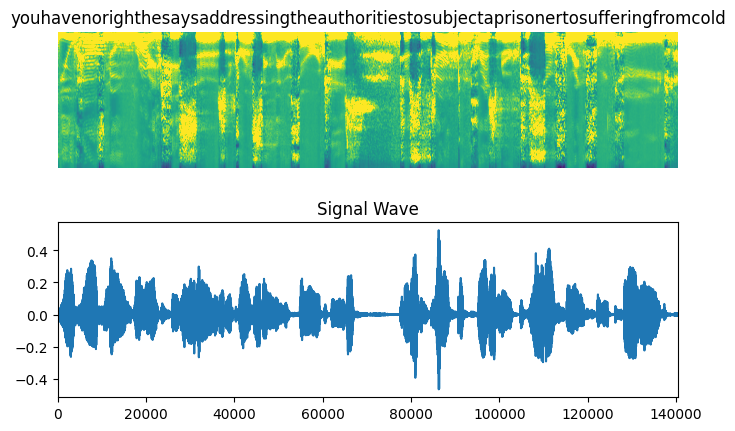

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])

    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    # Changed "file_name" to "file name" to match the column name in the DataFrame
    file = tf.io.read_file(wavs_path + list(df_train["file name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()



In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""

    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )

        # Bidirectional RNN layers
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer (moved outside the loop)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x) # Now 'dense_1' is created only once
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)

    return model

In [ ]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)

model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,627,455 (101.58 MB)

 Trainable params: 26,627,327 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                 label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                 targets.append(label)

        wer_score = wer(targets, predictions)

        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target     : {targets[i]}")
            print(f"Prediction : {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs.
epochs = 4

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []

for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

for i in np.random.randint(0, len(predictions), 5):
    print(f"Target     : {targets[i]}")
    print(f"Prediction : {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Save the trained model in the Keras format
model.save("speech_recognition_model.keras")
print("Model saved as 'speech_recognition_model.keras'")

Model saved as 'speech_recognition_model.keras'


Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━

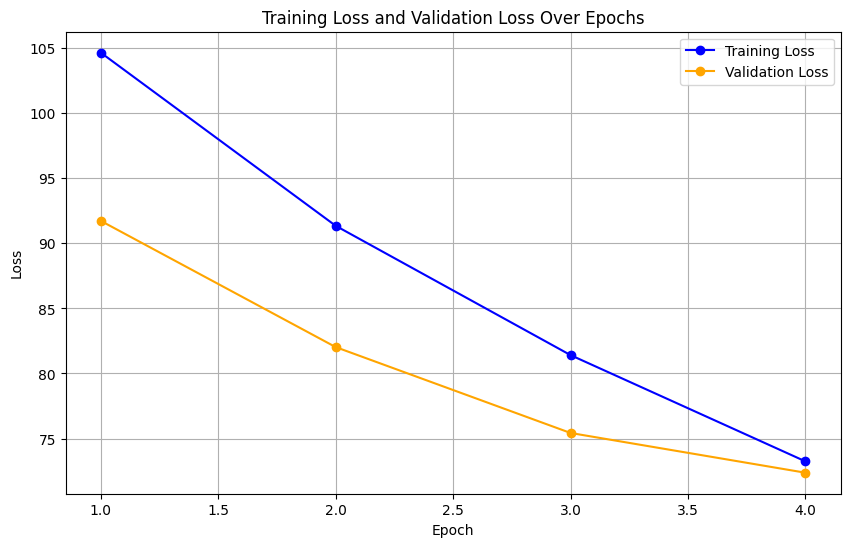

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = 4

# Callback function to check transcription on the val set
validation_callback = CallbackEval(validation_dataset)

# Train the model and collect the training history
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

# Extract the metrics from the history object
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
wer = getattr(validation_callback, 'wer_history', None)  # Assuming CallbackEval stores WER

# Plot Loss and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training Loss and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot WER if available
if wer:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(wer) + 1), wer, label='WER', marker='o', color='green')
    plt.title('Word Error Rate (WER) Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.ylim(0, 1.05)  # Ensuring the range stays between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()

**Testing our Input Audio**

In [ ]:
# Load the trained model
model = keras.models.load_model("speech_recognition_model.keras", custom_objects={"CTCLoss": CTCLoss})

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from jiwer import wer
import os
from google.colab import files  # Only for Google Colab environments

# Define constants for spectrogram generation
frame_length = 512  # Experiment with larger values for higher resolution
frame_step = 256  # A smaller step may help capture finer details
fft_length = 384  # Larger FFT length to capture more frequencies


# Character to number conversion (adjust as needed)
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?!" ]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=10)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# Encode a single audio sample
def encode_single_sample(wav_file, label):
    """
    Process the Audio
    """
    try:
        # 1. Read wav file
        file = tf.io.read_file(wav_file)

        # 2. Decode the wav file
        audio, _ = tf.audio.decode_wav(file)
        audio = tf.squeeze(audio, axis=-1)

        # 3. Change type to float
        audio = tf.cast(audio, tf.float32)

        # 4. Get the spectrogram
        spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

        # 5. We only need the magnitude, which can be derived by applying tf.abs
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.math.pow(spectrogram, 0.5)

        # 6. Normalization
        means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
        stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
        spectrogram = (spectrogram - means) / (stddevs + 1e-10)

        # 7. Process the label
        label = tf.strings.lower(label)  # Now 'label' is being used after being defined as a parameter

        # 8. Split the label
        label = tf.strings.unicode_split(label, input_encoding="UTF-8")

        # 9. Map the characters in label to numbers
        label = char_to_num(label)

        return spectrogram, label
    except Exception as e:
        print(f"Error in audio processing: {e}")
        return None, None

# Example: Predict the transcription of a single audio file
def predict_single_audio(wav_file_path, expected_transcription):
    """
    Given an audio file path, this function processes the audio,
    makes a prediction, and computes Word Error Rate (WER).
    """
    # Load model
    model_path = "speech_recognition_model.keras"
    if os.path.exists(model_path):
        try:
            model = keras.models.load_model(
                model_path,
                custom_objects={"CTCLoss": tf.keras.losses.CategoricalCrossentropy},
            )
            model.summary()  # Debug: Check model architecture
        except Exception as e:
            print(f"Error loading model: {e}")
            return
    else:
        print("Error: Model file not found.")
        return

    # Process the uploaded audio
    spectrogram, _ = encode_single_sample(wav_file_path, "")
    if spectrogram is not None:
        print(f"Spectrogram shape: {spectrogram.shape}")  # Debug
        print(f"Spectrogram sample values: {spectrogram.numpy()[:5, :5]}")  # Debug

        # Add a batch dimension to match the model's expected input
        spectrogram = tf.expand_dims(spectrogram, axis=0)

        # Predict the transcription
        try:
            predictions = model.predict(spectrogram)
            predicted_transcription = decode_batch_predictions(predictions)[0]
            print(f"Predicted Transcription: {predicted_transcription}")

            # Compute Word Error Rate (WER)
            wer_score = wer([expected_transcription], [predicted_transcription])
            print(f"Word Error Rate (WER): {wer_score:.4f}")
        except Exception as e:
            print(f"Error in model prediction: {e}")
    else:
        print("Error processing the uploaded audio file.")

# Upload the audio file
print("Please upload your audio file:")
uploaded = files.upload()

# Retrieve the uploaded file path (assuming it's the first uploaded file)
wav_file_path = list(uploaded.keys())[0]  # This gets the name of the first uploaded file
expected_transcription = "hello i am madhav from bmsce and i like deep learning"  # Enter the expected transcription

# Call the function with the uploaded file
predict_single_audio(wav_file_path, expected_transcription)


Please upload your audio file:


Saving LJ001-0001.wav to LJ001-0001.wav


Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,395,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 79,882,111 (304.73 MB)

 Trainable params: 26,627,327 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 53,254,656 (203.15 MB)

Spectrogram shape: (830, 193)
Spectrogram sample values: [[-0.04218453  1.7815294   3.6658516   2.1318998   4.412702  ]
 [-0.7561987  -0.7638883  -0.41934252 -0.42486778 -0.05110023]
 [-1.1602266  -0.26083127 -0.31290346 -0.94935507  0.21825159]
 [-0.0456775   0.10911727 -0.47292098  0.34732103  0.52593374]
 [ 0.85566646  0.9327284   0.9915215   1.2067913   1.4852004 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
Predicted Transcription: potinginthealesanswitwhitarapasotcocerddiferscromostifotfomaldartsacraftswresatedinhesoi
Word Error Rate (WER): 1.0000


**Visualization**

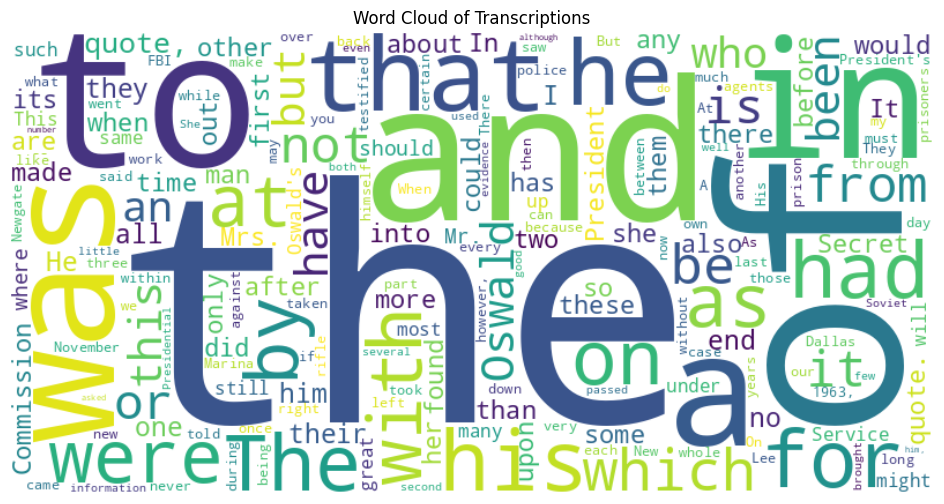

Top 10 words: [('the', 16648), ('of', 8690), ('and', 6336), ('to', 6247), ('in', 4381), ('a', 4081), ('was', 3729), ('that', 2846), ('he', 2159), ('his', 1898)]


In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Combine all transcriptions and split into words
all_words = ' '.join(metadata_df['transcription']).split()
word_counts = Counter(all_words)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Transcriptions')
plt.show()

# Top 10 most common words
top_words = word_counts.most_common(10)
print("Top 10 words:", top_words)


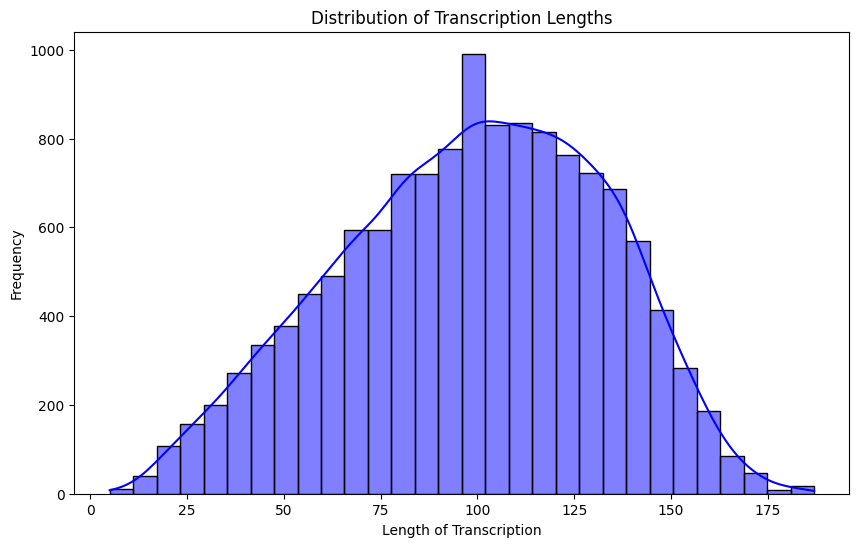

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column for transcription length
metadata_df['transcription_length'] = metadata_df['transcription'].apply(len)

# Plot the distribution of transcription lengths
plt.figure(figsize=(10, 6))
sns.histplot(metadata_df['transcription_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Transcription Lengths')
plt.xlabel('Length of Transcription')
plt.ylabel('Frequency')
plt.show()
